In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importations
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, BatchSampler, random_split
from itertools import chain

from src.covid_cytof_dataset import CovidCytofDataset
from src.models.configurable_nn import ConfigurableNeuralNetwork
from src.models.simple_nn import SimpleNeuralNetwork
from src.trainer import Trainer

sns.set_theme()

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
NUM_CELLS_PER_PATIENTS = 10000
BATCH_SIZE = 100

In [ ]:
data = CovidCytofDataset("./data/attachments/COVID_CYTOF_BASIC_METADATA_STATUS_AGE_GROUP_SEX.xlsx", "./data",
                         NUM_CELLS_PER_PATIENTS)

/home/evann/.cache/pypoetry/virtualenvs/covid-cytof-NoJZp_V7-py3.10/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Loading fcs data:


 70%|█████████████████████████████▉             | 69/99 [04:58<14:59, 29.99s/it]

In [7]:
# train_data, test_data = random_split(list(BatchSampler(data, batch_size=NUM_CELLS_PER_PATIENS, drop_last=False)),
#                                      [0.8, 0.2])
# train_data, test_data = list(chain.from_iterable(train_data)), list(chain.from_iterable(test_data))

train_data, test_data = random_split(data, [0.8, 0.2])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

SimpleNeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=61, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


100%|█████| 50/50 [07:32<00:00,  9.06s/it, Loss=0.1398, Accuracy=80%, F1=0.6207]


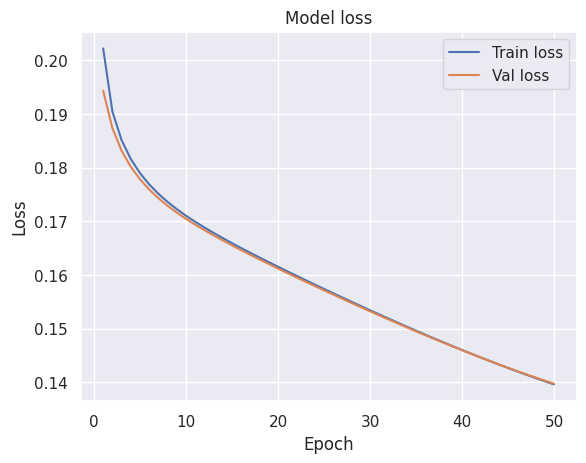

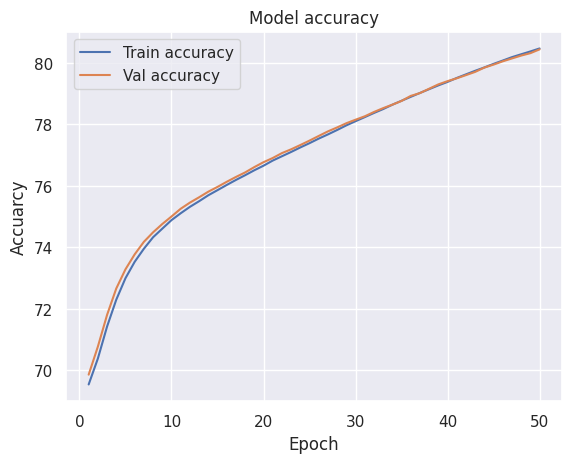

In [7]:
model = SimpleNeuralNetwork(data.data.shape[1], 500, 1).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

trainer = Trainer(model, optimizer, loss_fn, device, epochs=50, silent=True)
trainer.run(train_dataloader, test_dataloader)
trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_f1()

100%|█████| 50/50 [06:45<00:00,  8.11s/it, Loss=0.1775, Accuracy=74%, F1=0.4217]


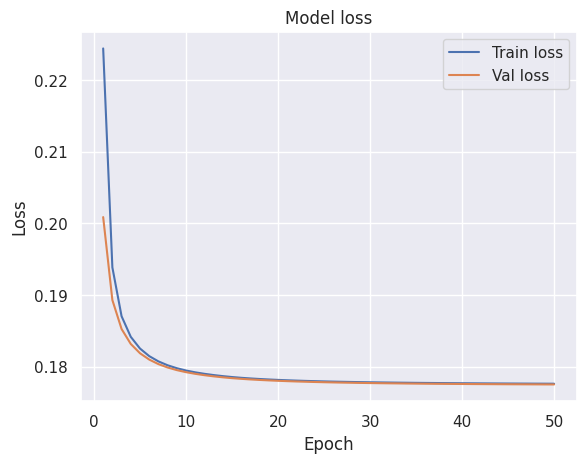

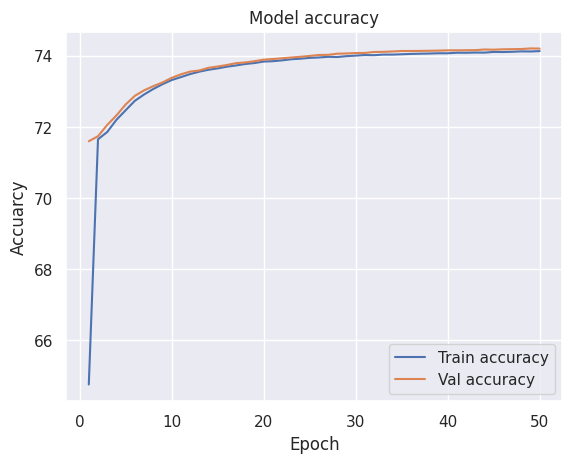

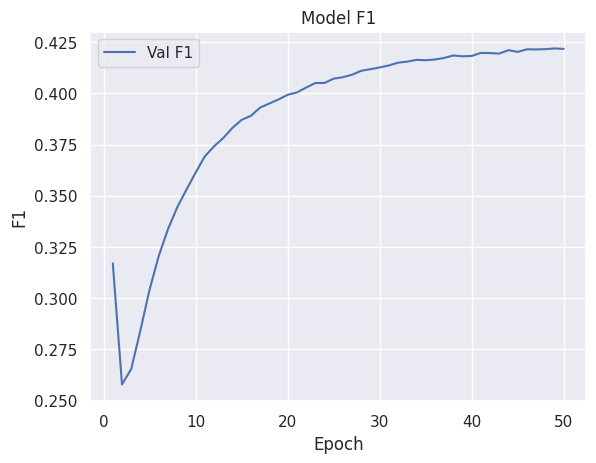

In [8]:
model1 = ConfigurableNeuralNetwork([
    data.data.shape[1],
    1
]).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=1e-3)

trainer = Trainer(model1, optimizer, loss_fn, device, epochs=50, silent=True)

trainer.run(train_dataloader, test_dataloader)

trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_f1()

100%|███| 200/200 [30:00<00:00,  9.00s/it, Loss=0.1033, Accuracy=86%, F1=0.7499]


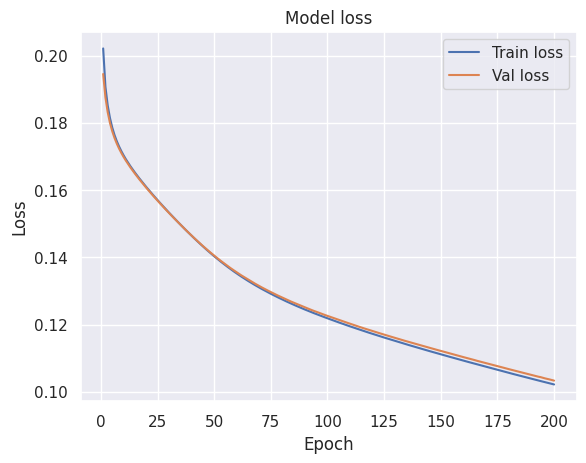

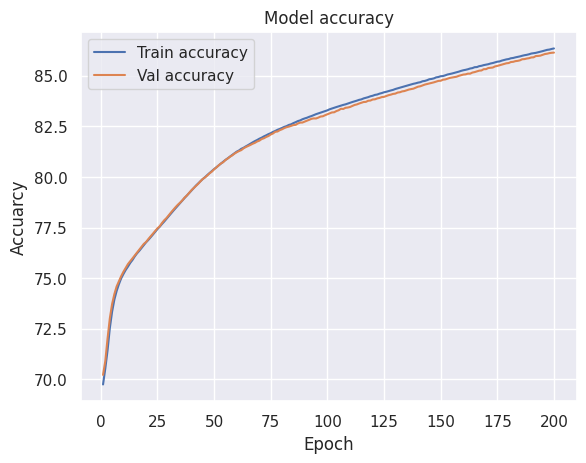

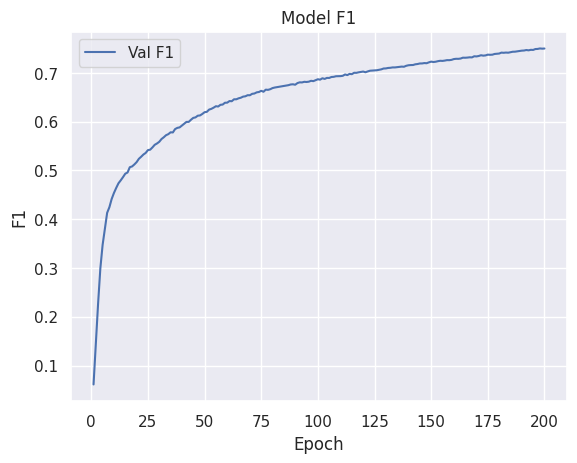

In [9]:
model2 = ConfigurableNeuralNetwork([
    data.data.shape[1],
    500,
    1
]).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-3)

trainer = Trainer(model2, optimizer, loss_fn, device, epochs=200, silent=True)

trainer.run(train_dataloader, test_dataloader)

trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_f1()

100%|█████| 50/50 [08:07<00:00,  9.75s/it, Loss=0.1448, Accuracy=80%, F1=0.5928]


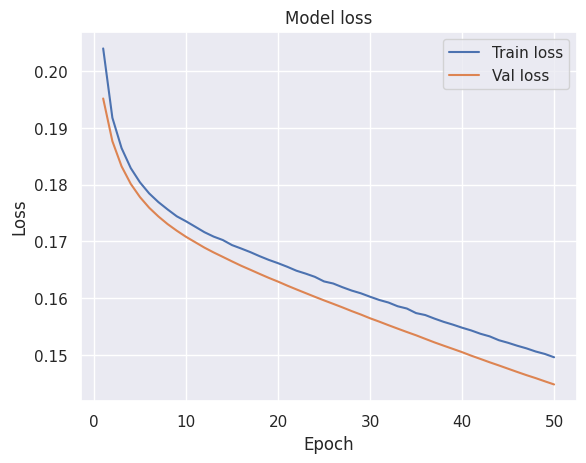

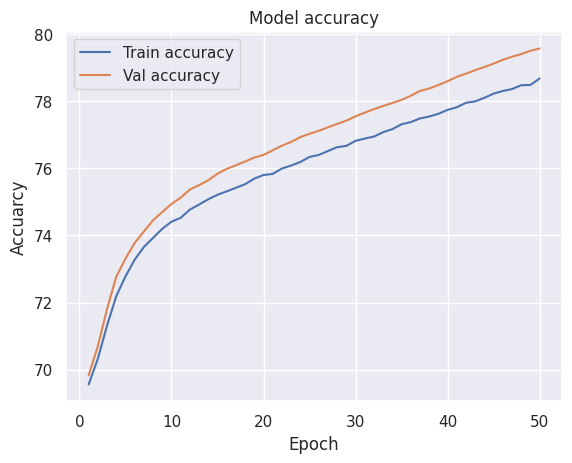

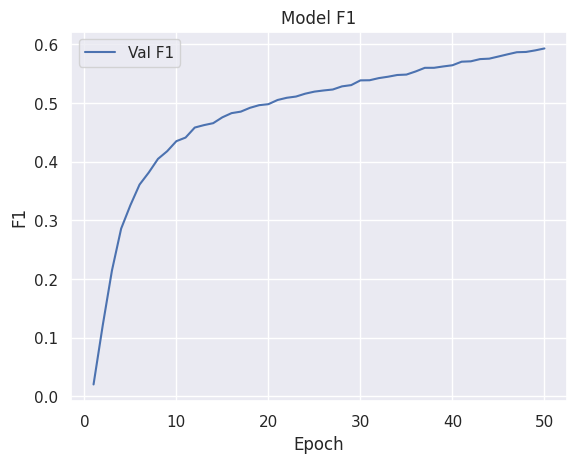

In [10]:
model2 = ConfigurableNeuralNetwork([
    data.data.shape[1],
    500,
    1
], dropout=0.25, dropout_indexs=[1]).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-3)

trainer = Trainer(model2, optimizer, loss_fn, device, epochs=50, silent=True)

trainer.run(train_dataloader, test_dataloader)

trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_f1()

100%|█████| 50/50 [09:16<00:00, 11.13s/it, Loss=0.1403, Accuracy=80%, F1=0.6192]


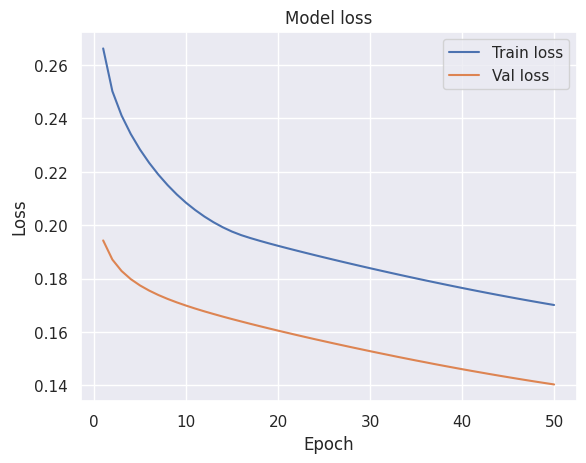

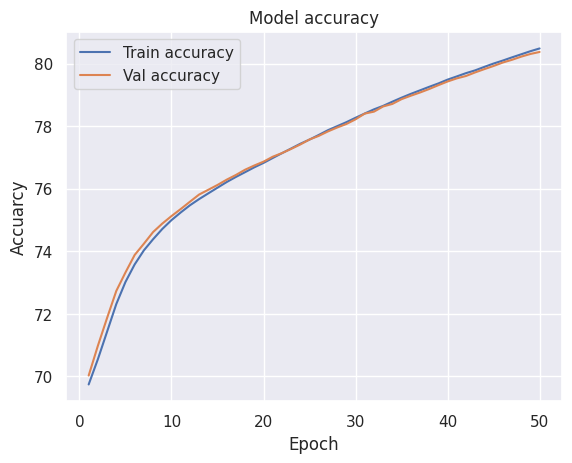

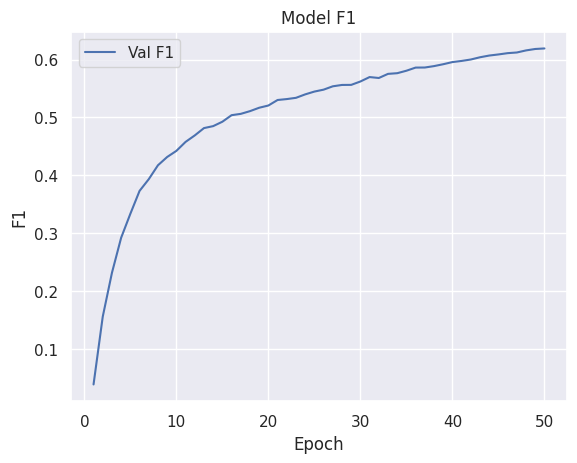

In [11]:
model2 = ConfigurableNeuralNetwork([
    data.data.shape[1],
    500,
    1
]).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-3)

trainer = Trainer(model2, optimizer, loss_fn, device, epochs=50, L1_regularization=True, silent=True)

trainer.run(train_dataloader, test_dataloader)

trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_f1()

In [12]:
model2 = ConfigurableNeuralNetwork([
    data.data.shape[1],
    500,
    1
], dropout=0.25, dropout_indexs=[1]).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-3)

trainer = Trainer(model2, optimizer, loss_fn, device, epochs=50, L1_regularization=True, silent=True)

trainer.run(train_dataloader, test_dataloader)

trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_f1()

 80%|████ | 40/50 [08:22<02:05, 12.56s/it, Loss=0.1513, Accuracy=78%, F1=0.5620]


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasLtMatmul( ltHandle, computeDesc.descriptor(), &alpha_val, mat1_ptr, Adesc.descriptor(), mat2_ptr, Bdesc.descriptor(), &beta_val, result_ptr, Cdesc.descriptor(), result_ptr, Cdesc.descriptor(), &heuristicResult.algo, workspace.data_ptr(), workspaceSize, at::cuda::getCurrentCUDAStream())`

100%|███| 200/200 [39:00<00:00, 11.70s/it, Loss=0.0567, Accuracy=92%, F1=0.8706]


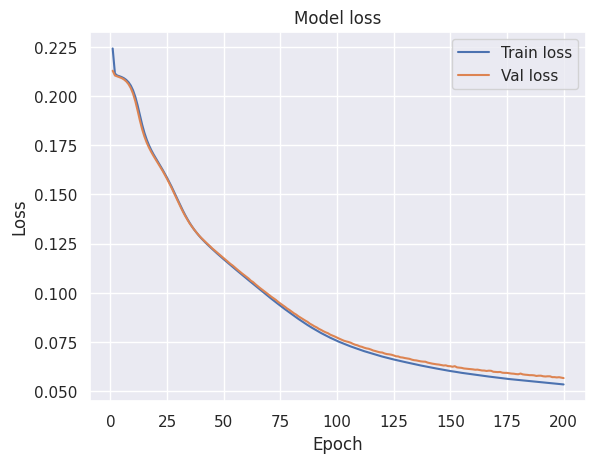

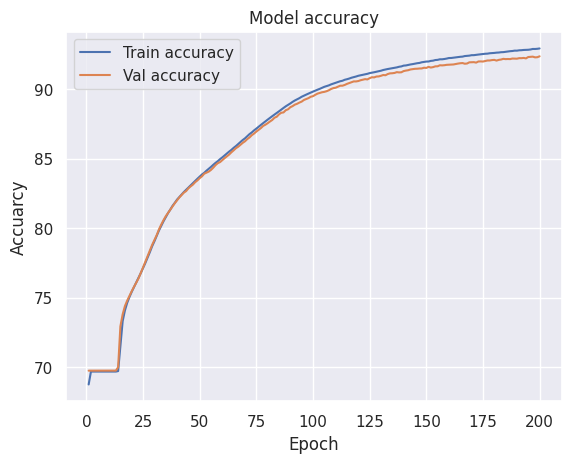

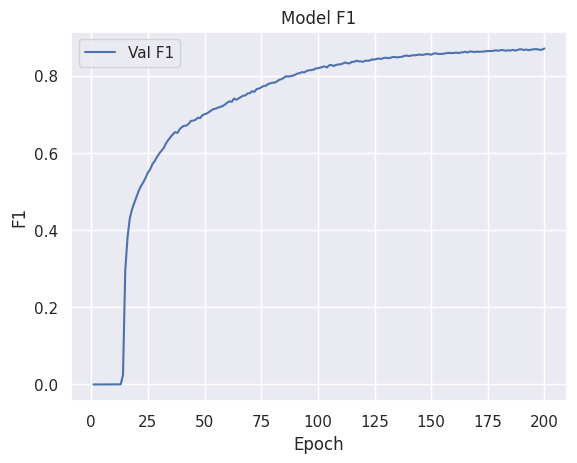

In [12]:
model3 = ConfigurableNeuralNetwork([
    data.data.shape[1],
    100,100,100,100,
    1
]).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=1e-3)

trainer = Trainer(model3, optimizer, loss_fn, device, epochs=200, silent=True)

trainer.run(train_dataloader, test_dataloader)

trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_f1()